# TASK 1: Image reading and displaying

Image reading is a core functionality of any image processing algorithm and often available in the form of a function ‘imread()’. In this task you need to write your own ‘imread()’ function which can read .pgm images (pgm test dataset is given with this assignment). Once you read your image(s), you need display them with existing library call.

In [ ]:
%%capture
import matplotlib.pyplot as plt
import numpy as np
import os

import pywt
import pywt.data
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

from sklearn.metrics import mean_squared_error
from math import sqrt

In [4]:
def convert_pgm_to_matrix(pgm):
    """
    convert_pgm_to_matrix
    read PGM images and return a matrix that store image pixels in grayscale

    Input: PGM image
    Output: image pixels in grayscale 
    """
    with open(pgm, 'rb') as f:
        # Check Format
        # which is the signature of the image file and PGM file format identification
        format = f.readline().decode("utf-8").rstrip('\n')
        if format != 'P5':
            print("No p5", format)
            raise "This function only support PGM with P5 format"

        # Check comment
        next_line = f.readline().decode("utf-8").rstrip('\n')
        while next_line.startswith('#'):
            next_line = f.readline().decode("utf-8").rstrip('\n')
        
        # Check Dimension
        shape = next_line.split(" ")
        num_rows = int(shape[1])
        num_columns = int(shape[0])

        # Get maximum grey level specify in the image
        max_grey_level = int(f.readline().decode("utf-8").rstrip('\n'))

        # Read pixel data
        pixel_data = f.read()
            
        # Convert binary data to ASCII
        pixels = [byte for byte in pixel_data]
        pic = np.array(pixels, dtype=int).reshape(num_rows, num_columns)

    # Create an image with that grayscale value
    ## TODO: Check why I need to normalize data in order to show
    # Normalize to the range [0, 1]
    grayscale_value = pic / max_grey_level  
    image_matrix = np.full((num_rows, num_columns), grayscale_value)

    return image_matrix


def show_image_greyscale(image_matrix):
    """
    show_image_greyscale
    shows image in greyscale

    Input: matrix of image pixels
    Output: shows image
    """
    plt.imshow(image_matrix, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

# Convolution
Transform spatial image to frequency domain using wavelet transformation on Haar Coefficient

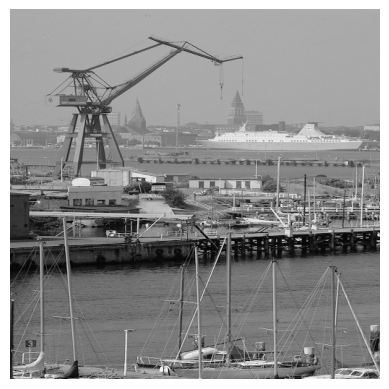

In [8]:
# Load image
im = convert_pgm_to_matrix("./Dataset/kiel.pgm")
show_image_greyscale(im)

In [9]:
# Image Utility function
def show_pic(pic):
    plt.imshow(pic, cmap=plt.cm.gray)

def show_images_4_grids(LL, LH, HL, HH, level):
    titles = ['Approximation', ' Horizontal detail', 'Vertical detail', 'Diagonal detail']
    fig = plt.figure(figsize=(8, 8))
    for i, a in enumerate([LL, LH, HL, HH]):
        ax = fig.add_subplot(2, 2, i + 1)
        ax.imshow(a, cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.tight_layout()
    fig.text(0.37, 1, f"Wavelet transformation Level {level}")
    plt.show()

## Forward and Inverse Wavelet Transform

In [10]:
def convolve_by_column(m, filter):
    num_row, num_col = m.shape
    result = np.zeros((num_row - 1, num_col))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r:r+2, c]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)
    
    return result

def convolve_by_row(m, filter):
    num_row, num_col = m.shape
    result = np.zeros((num_row, num_col - 1))
    for r in range (num_row):
        for c in range (num_col):
            window = m[r, c:c+2]
            if window.shape[0] != 2:
                break

            result[r, c] = np.dot(filter, window)
    
    return result


def upsample_rows(matrix):
    """
    Upsample a 2D array along rows by inserting zeros between rows.
    """
    rows, cols = matrix.shape
    upsampled = np.zeros((2 * rows, cols))
    upsampled[::2, :] = matrix 

    return upsampled


def upsample_cols(matrix):
    """
    Upsample a 2D array along columns by inserting zeros between columns.
    """
    rows, cols = matrix.shape
    upsampled = np.zeros((rows, 2 * cols))
    upsampled[:, ::2] = matrix

    return upsampled

def downsample_cols(im):
    return im[:, ::2]

def downsample_rows(im):
    return im[::2, :]

## TODO: Write this function by myself
def symmetric_pad(image):
    # Calculate padding needed
    pad_width = 1
    
    # Symmetric padding on both sides
    padded_image = np.pad(image, 
                           ((pad_width//2, pad_width - pad_width//2), 
                            (pad_width//2, pad_width - pad_width//2)), 
                           mode='symmetric')
    return padded_image

def add_frequency(a, b):
    if a.shape == b.shape:
        return a + b
    
    diff_in_rows = a.shape[0] - b.shape[0]
    if diff_in_rows > 0:
        a = a[:-diff_in_rows, :]
    elif diff_in_rows < 0:
        b = b[:diff_in_rows, :]

    diff_in_cols = a.shape[1] - b.shape[1]
    if diff_in_cols > 0:
        a = a[:, :-diff_in_cols]
    elif diff_in_cols < 0:
        b = b[:, :diff_in_cols]
    
    return a+b



In [11]:
def forward_wavelet_transform(im):
    low_pass_filter = np.array([1, 1]) / np.sqrt(2)
    high_pass_filter = np.array([-1, 1]) / np.sqrt(2)

    L = downsample_cols(convolve_by_row(symmetric_pad(im), low_pass_filter))
    H = downsample_cols(convolve_by_row(symmetric_pad(im), high_pass_filter))
    print('L shape=', L.shape)

    LL = downsample_rows(convolve_by_column(L, low_pass_filter))
    LH = downsample_rows(convolve_by_column(L, high_pass_filter))
    HL = downsample_rows(convolve_by_column(H, low_pass_filter))
    HH = downsample_rows(convolve_by_column(H, high_pass_filter))

    return LL, LH, HL, HH

def inverse_wavelet_transform(LL, LH, HL, HH):
    low_pass_filter = np.array([1, 1]) / np.sqrt(2)
    high_pass_filter = np.array([1, -1]) / np.sqrt(2)

    reconstructed_L = add_frequency(convolve_by_column(upsample_rows(LH), high_pass_filter), convolve_by_column(upsample_rows(LL), low_pass_filter))
    reconstructed_H = convolve_by_column(upsample_rows(HH), high_pass_filter) + convolve_by_column(upsample_rows(HL), low_pass_filter)

    reconstructed_image = convolve_by_row(upsample_cols(symmetric_pad(reconstructed_L)), low_pass_filter) + convolve_by_row(upsample_cols(symmetric_pad(reconstructed_H)), high_pass_filter)

    # Crop to match the original size
    rows, cols = LL.shape[0] * 2, LL.shape[1] * 2
    return reconstructed_image[:rows, :cols]

In [12]:
def forward_wavelet_transform_with_level(image, level):
    result = []
    for l in range(1, level+1):
        LL, LH, HL, HH = forward_wavelet_transform(image)
        image = LL
        show_images_4_grids(LL, LH, HL, HH, l)
        
        result.append(
            {
                "LL": LL, 
                "LH": LH, 
                "HL": HL, 
                "HH": HH
            }
        )
    
    return result

def inverse_wavelet_transform_many_levels(res):
    level = len(res)
    reconstructed_im = None
    
    for l in range(level - 1, -1, -1):
        LL, LH, HL, HH = res[l]["LL"], res[l]["LH"], res[l]["HL"], res[l]["HH"]
        if not reconstructed_im is None:
            LL = reconstructed_im
        
        reconstructed_im = inverse_wavelet_transform(LL, LH, HL, HH)

    return reconstructed_im
        

In [17]:
# Run all image

# dataset_directory = './Dataset'
# for filename in os.listdir(dataset_directory):
#     if filename.endswith(".pgm"):
#         file_with_directory = dataset_directory + "/" + filename
#         print(file_with_directory)
#         im = convert_pgm_to_matrix(file_with_directory)
#         # show_image_greyscale(im)

#         res = forward_wavelet_transform_with_level(im, 3,)
#         reconstructed_image = inverse_wavelet_transform_many_levels(res)
#         show_pic(reconstructed_image)

# Calculate MSE

In [14]:
def calculate_mse(original_image, reconstructed_image):
    num_rows, num_cols = original_image.shape
    reconstructed_image = reconstructed_image[:num_rows, :num_cols]

    return mean_squared_error(original_image, reconstructed_image)

## Claude recommendation

In [15]:
def inverse_wavelet_transform_2(LL, LH, HL, HH):
    # Define filters
    low_pass_filter = np.array([1, 1]) / np.sqrt(2)
    high_pass_filter = np.array([1, -1]) / np.sqrt(2)
    
    # Calculate target dimensions
    target_rows, target_cols = LL.shape[0] * 2, LL.shape[1] * 2
    
    # Helper function for centering
    def center_shift(array):
        rows, cols = array.shape
        row_shift = (rows % 2) / 2
        col_shift = (cols % 2) / 2
        return np.roll(np.roll(array, int(row_shift), axis=0), int(col_shift), axis=1)
    
    # Apply centering before reconstruction
    LL = center_shift(LL)
    LH = center_shift(LH)
    HL = center_shift(HL)
    HH = center_shift(HH)
    
    # Reconstruction process
    reconstructed_L = add_frequency(
        convolve_by_column(upsample_rows(LH), high_pass_filter),
        convolve_by_column(upsample_rows(LL), low_pass_filter)
    )
    
    reconstructed_H = (
        convolve_by_column(upsample_rows(HH), high_pass_filter) + 
        convolve_by_column(upsample_rows(HL), low_pass_filter)
    )
    
    # Apply symmetric padding and reconstruct
    reconstructed_image = (
        convolve_by_row(upsample_cols(symmetric_pad(reconstructed_L)), low_pass_filter) +
        convolve_by_row(upsample_cols(symmetric_pad(reconstructed_H)), high_pass_filter)
    )
    
    # Center the final result
    reconstructed_image = center_shift(reconstructed_image)
    
    # Apply phase correction if needed
    if (target_rows % 2 == 1) or (target_cols % 2 == 1):
        reconstructed_image = np.roll(np.roll(reconstructed_image, -1, axis=0), -1, axis=1)
    
    # Crop to match the original size
    return reconstructed_image[:target_rows, :target_cols]

In [20]:
def inverse_wavelet_transform_many_levels_2(res):
    level = len(res)
    reconstructed_im = None
    
    for l in range(level - 1, -1, -1):
        LL, LH, HL, HH = res[l]["LL"], res[l]["LH"], res[l]["HL"], res[l]["HH"]
        if not reconstructed_im is None:
            LL = reconstructed_im
        
        reconstructed_im = inverse_wavelet_transform_2(LL, LH, HL, HH)

    return reconstructed_im

# Denoise

In [5]:
file = './Noisy/noisy_1/boats.pgm'
im = convert_pgm_to_matrix(file)

# res = forward_wavelet_transform_with_level(im, 3,)
# reconstructed_image = inverse_wavelet_transform_many_levels_2(res)
show_pic(im)

No p5 P5 720 576 255


TypeError: exceptions must derive from BaseException

In [23]:
calculate_mse(im, reconstructed_image)

np.float64(0.03107756862040895)